## <font color='green'> MNIST - Clustering (Dense Matrix)<font>

### <font color='green'> 1. Description<font>

Clustering using MNIST Digit Recognition dataset.
Dataset is downloaded from tensorflow by using `tensorflow.keras.datasets.mnist.load_data()` method; so please install tensorflow.

The MNIST database (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used for training various image processing systems. In this demo we will use this dataset to correctly cluster similar digits.

### <font color='green'> 2. Data Preprocessing<font>

For MNIST Digits dataset we will perform some data preparation and data cleaning steps.

In [1]:
%%capture
import os
import time
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn import metrics
from collections import OrderedDict

In [2]:
def preprocess_data():
    '''
    Load the mnist data and perform pre-processing
    '''
    # Load MNIST Digits dataset
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    x = np.concatenate((x_train, x_test))
    y = np.concatenate((y_train, y_test))
    x = x.reshape((x.shape[0], -1)).astype('float32')
    x = np.divide(x, 255.)
    return x, y

In [3]:
#---- Data Loading and Preparation ----

X, y = preprocess_data()
n_clusters = len(np.unique(y))
print("Dataset contains {} samples".format(X.shape))
print("Dataset contains {} classes".format(n_clusters))

Dataset contains (70000, 784) samples
Dataset contains 10 classes


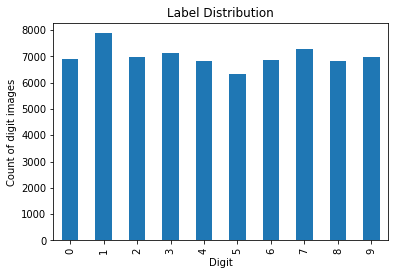

In [4]:
# Label distribution summary
import matplotlib.pyplot as plt
val, count = np.unique(y, return_counts=True)
label = np.asarray((val, count)).T
labels_df = pd.DataFrame(data=label)
ax = labels_df[1].plot(kind='bar', title='Label Distribution').\
     set(xlabel="Digit", ylabel="Count of digit images")

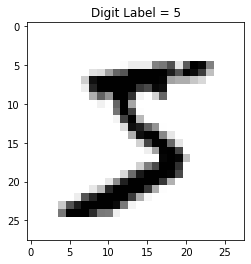

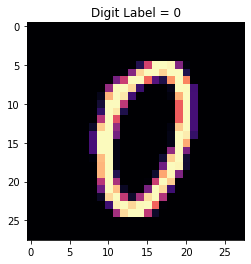

In [5]:
plt.imshow(X[0].reshape(28, 28), cmap = 'binary')
plt.title('Digit Label = {}'.format(y[0]))
plt.show()
plt.imshow(X[1000].reshape(28, 28), cmap = 'magma')
plt.title('Digit Label = {}'.format(y[1000]))
plt.show()

### <font color='green'> 3. Algorithm Evaluation<font>

In [6]:
train_time = []
homogeneity = []
estimator_name = []

In [7]:
def evaluate(estimator, estimator_nm, X, y):
    '''
    To generate performance report for both frovedis and sklearn estimators
    '''
    estimator_name.append(estimator_nm)

    start_time = time.time()
    y_pred = estimator.fit_predict(X)
    train_time.append(round(time.time() - start_time, 4))

    homogeneity.append(metrics.homogeneity_score(y.ravel(), y_pred))

#### 3.1 KMeans Clustering

In [8]:
#Demo: KMeans Clustering
import frovedis
TARGET = "kmeans"
from frovedis.exrpc.server import FrovedisServer
FrovedisServer.initialize("mpirun -np 8 " + os.environ["FROVEDIS_SERVER"])
from frovedis.mllib.cluster import KMeans as frovKM
f_est = frovKM(n_clusters=n_clusters, init='random', algorithm='full', n_init=1)
E_NM = TARGET + "_frovedis_" + frovedis.__version__
evaluate(f_est, E_NM, X, y)
f_est.release()
FrovedisServer.shut_down()

import sklearn
from sklearn.cluster import KMeans as skKM
s_est = skKM(n_clusters=n_clusters, init='random', algorithm='full', n_init=1)
E_NM = TARGET + "_sklearn_" + sklearn.__version__
evaluate(s_est, E_NM, X, y)

#### 3.2 Agglomerative Clustering

In [9]:
#Demo: Agglomerative Clustering
import frovedis
TARGET = "agglomerative"
from frovedis.exrpc.server import FrovedisServer
FrovedisServer.initialize("mpirun -np 8 " + os.environ["FROVEDIS_SERVER"] )
from frovedis.mllib.cluster import AgglomerativeClustering as frovAgglomerative

# for Agglomerative performed PCA decomposition
from frovedis.mllib.decomposition import PCA
x_pca = PCA(n_components=100).fit_transform(X)

f_est = frovAgglomerative(n_clusters=n_clusters, linkage="average")
E_NM = TARGET + "_frovedis_" + frovedis.__version__
evaluate(f_est, E_NM, x_pca, y)
f_est.release()
FrovedisServer.shut_down()

import sklearn
from sklearn.cluster import AgglomerativeClustering as skAgglomerative
s_est = skAgglomerative(n_clusters=n_clusters, linkage="average")
E_NM = TARGET + "_sklearn_" + sklearn.__version__
evaluate(s_est, E_NM, x_pca, y)

#### 3.3 DBSCAN Clustering

In [10]:
#Demo: DBSCAN Clustering
import frovedis
TARGET = "dbscan"
from frovedis.exrpc.server import FrovedisServer
FrovedisServer.initialize("mpirun -np 8 " + os.environ["FROVEDIS_SERVER"] )
from frovedis.mllib.cluster import DBSCAN as frovDB
f_est = frovDB(eps=4.52, metric="euclidean", algorithm="brute")
E_NM = TARGET + "_frovedis_" + frovedis.__version__

# we are evaluating DBSCAN with first 50k samples due to memeory issue at Frovedis Server when trying with full data 
evaluate(f_est, E_NM, X[:50000,:], y[:50000])     
f_est.release()
FrovedisServer.shut_down()

import sklearn
from sklearn.cluster import DBSCAN as skDB
s_est = skDB(eps=4.52, metric="euclidean", algorithm="brute", n_jobs=12)
E_NM = TARGET + "_sklearn_" + sklearn.__version__
evaluate(s_est, E_NM, X[:50000,:], y[:50000])

### <font color='green'> 4. Performance summary<font>

In [11]:
summary = pd.DataFrame(OrderedDict({ "estimator": estimator_name,
                                     "train time": train_time, 
                                     "homogeneity_score": homogeneity
                                  }))
summary

,estimator,train time,homogeneity_score
0,kmeans_frovedis_0.9.10,0.9357,0.485315
1,kmeans_sklearn_0.24.1,1.9387,0.496518
2,agglomerative_frovedis_0.9.10,16.8117,0.163916
3,agglomerative_sklearn_0.24.1,361.5187,0.163916
4,dbscan_frovedis_0.9.10,1.5997,0.185969
5,dbscan_sklearn_0.24.1,58.5784,0.185466
